In [35]:
import os.path as op
import pandas as pd
import numpy as np
import math
import glob
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.visualization as av

#Interferon classes
import auto_VP_run as auto_vp
import guider_observations as go
import dither_observations as do
import VP_fits_frame as vpf
import IFU_spectrum as ifu_spec

import interpolate_IFU as ifu_intp
import emission_line_fitting_emcee as elf
import model_line_functions as mlf

# Basic VP Reduction 
- Modified version of Remedy developed by Greg Ziemann for VIRUS 
- https://github.com/grzeimann/Remedy
- Returns fiber extracted spectra in e-/s with wavelength solution for each non calibration frame
- Data product is multiextension fits file with frames containing:
        - sky subtracted spectra from fibers with no detected continuum in the frame 
        - non sky subtracted spectra 
        - error spectra 
        
- Can be installed on TACC or locally 
        - The code is large because it provides reduction to multiple instruments 
        - git clone https://github.com/grzeimann/Remedy.git
       
python /path/Remedy/reduce_virusp.py path/folder_with_data OUTPUTDIR -b -ra

## Example Remedy Data Product

In [36]:
def plot_Remedy_frame(filename, fits_ext):
    fig, ax = plt.subplots(1,1,figsize=(20,8))

    hdu = fits.open(filename)
    dat = hdu[fits_ext].data
    norm = av.ImageNormalize(dat, interval=av.ZScaleInterval(),
                      stretch=av.SqrtStretch())
    ax.imshow(dat, norm=norm, cmap='Greys')
    ax.set_title('Fits Extension: '+str(fits_ext)+' :'+str(np.nanmedian(dat)), fontsize=30)
    ax.set_ylabel('Fiber Number', fontsize=25)
    ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

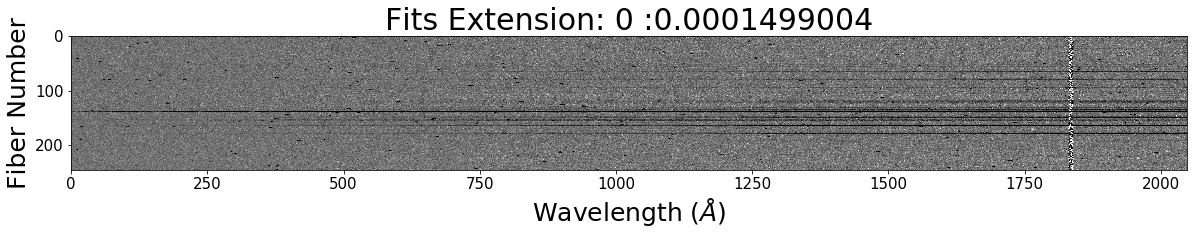

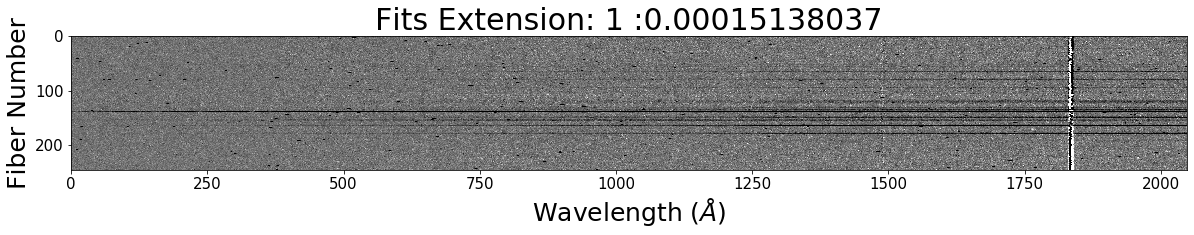

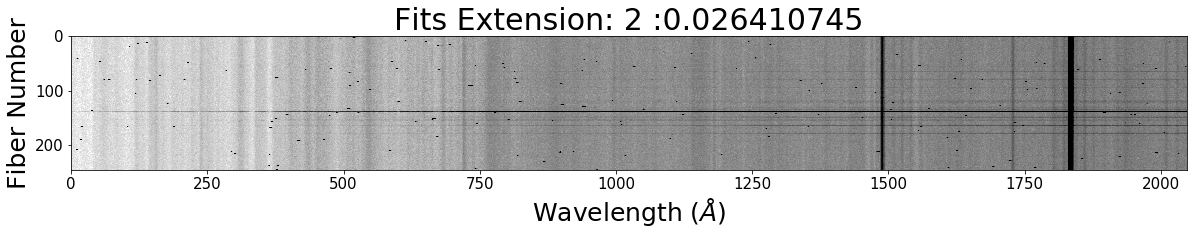

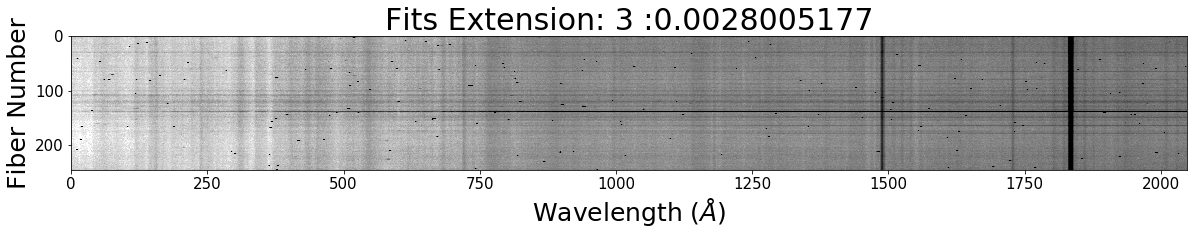

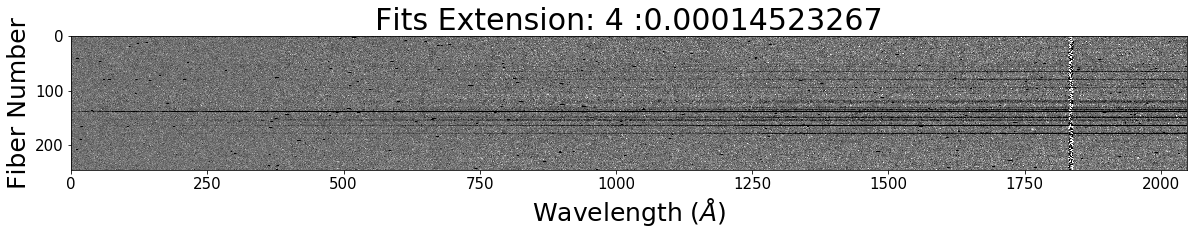

In [37]:
#fits_ex = '../20210411/redux/COOLJ1234_dither_1_20210411T045930_multi.fits'
fits_ex = '/Volumes/B_SS/VIRUS_P/VP_reduction/20210411/redux/COOLJ0931_dither_1_20210411T030846_multi.fits'
ext_lis = [0,1,2,3,4 ]
for i in ext_lis:
    plot_Remedy_frame(fits_ex, i)

# My Code - Interferon

- take in Remedy data products for VP and preform:
    - allow for user run custom sky subtraction
    - dither normalization from guider frames 
    - flux calbiration using standard stars
    - build data cube - interpolate over dither set while conserving flux
    - spectral extraction over aperature 
    - emission line fitting using Bayesian scheme
    - build emission line images 
    - normalize overlapping fields 
    
- contains 6 classes that produce objects at different levels that you are able to operate on

## Define data path

In [38]:
data_path = '../20210411/redux'
guider_path = '../20210411/guider'
dith_file = 'VP_config/dith_vp_6subdither.csv'

##   guider_observations( )
- object describing a set of guider frame observations

In [39]:
guid = go.guider_observations(guider_path)

In [40]:
guid.guider_df.head(5)

,filename,obs_datetime,exptime(s)
0,../20210411/guider/guider12123.fits,2021-04-11 18:04:38.490000,4.0
1,../20210411/guider/guider9551.fits,2021-04-11 14:51:54.410000,4.0
2,../20210411/guider/guider9552.fits,2021-04-11 14:51:58.940000,4.0
3,../20210411/guider/guider3086.fits,2021-04-11 06:49:36.930000,4.0
4,../20210411/guider/guider3087.fits,2021-04-11 06:49:41.410000,4.0


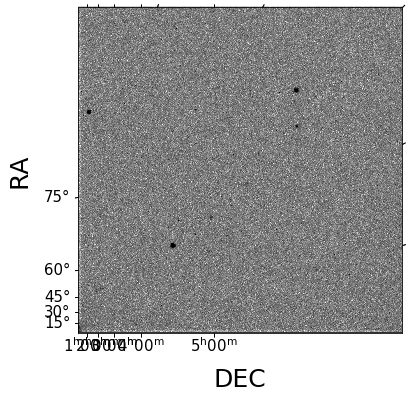

In [41]:
guid.inspect_guider_frame(500)

In [36]:
ex_source_df = guid.find_guide_stars(500)
ex_source_df

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,147.860364,136.181926,0.716914,-0.041521,-0.020829,121,0.0,3754.0,9.936979,-2.493136
1,2,207.786895,180.567434,0.773554,-0.005448,0.163885,121,0.0,3136.0,1.000273,-0.000297
2,3,28.382504,204.032891,0.345378,-0.000291,-0.477586,121,0.0,3113.0,1.345606,-0.322295
3,4,342.451685,322.457233,0.761252,0.121608,-0.334084,121,0.0,3162.0,1.377321,-0.347588
4,5,16.465724,345.051219,0.625932,-0.107796,-0.081938,121,0.0,3309.0,3.910758,-1.480652
5,6,341.645377,379.253468,0.734413,-0.092885,-0.039734,121,0.0,3442.0,5.324930,-1.815785


In [37]:
ex_source_df2 = guid.measure_guide_star_params(500, ex_source_df)
ex_source_df2

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,xcentroid_fit,ycentroid_fit,fwhm(arcseconds),flux_fit,mag_fit
0,1,147.860364,136.181926,0.716914,-0.041521,-0.020829,121,0.0,3754.0,9.936979,-2.493136,147.831242,136.173136,2.010461,2918.248288,-8.662806
1,2,207.786895,180.567434,0.773554,-0.005448,0.163885,121,0.0,3136.0,1.000273,-0.000297,207.833968,180.621671,1.888319,284.955638,-6.136943
2,3,28.382504,204.032891,0.345378,-0.000291,-0.477586,121,0.0,3113.0,1.345606,-0.322295,28.073142,203.910045,0.444888,160.517837,-5.513808
3,4,342.451685,322.457233,0.761252,0.121608,-0.334084,121,0.0,3162.0,1.377321,-0.347588,342.392371,322.538629,1.813271,374.427483,-6.433419
4,5,16.465724,345.051219,0.625932,-0.107796,-0.081938,121,0.0,3309.0,3.910758,-1.480652,16.450381,345.065430,2.055632,1201.182066,-7.699022
5,6,341.645377,379.253468,0.734413,-0.092885,-0.039734,121,0.0,3442.0,5.324930,-1.815785,341.614750,379.272546,2.010346,1597.585748,-8.008660


##   VP_fits_frame( )
- object describing a single exposure

In [5]:
file_ex = '../20210411_orig/test/COOLJ0931_dither_1_20210411T030846_multi3.fits'
fits_ex = vpf.VP_fits_frame(file_ex, 0) #guide_obs=guid

In [6]:
fits_ex.dith_num

1

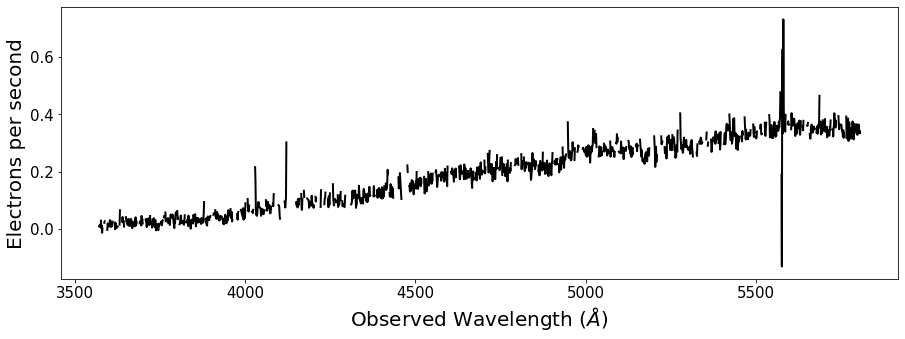

In [7]:
fits_ex.build_frame_sum_spec(plot=True)

In [24]:
file_list = glob.glob(data_path+'/COOLJ0931*_multi.fits')
dith_df = pd.read_csv(dith_file, skiprows=2)

ex_fits_lis = []
for i in file_list:
    fits_ex = vpf.VP_fits_frame(i, 0)
    print(fits_ex.dith_num, fits_ex.RA, fits_ex.DEC)
    ex_fits_lis.append(fits_ex)

1 142.92399999999998 -6.736972222222223
2 142.92020833333333 -6.737638888888889
3 142.91824999999997 -6.738138888888889
4 142.91620833333332 -6.737555555555556
5 142.91337499999997 -6.737
6 142.91158333333334 -6.738166666666666


In [25]:
d1_ra = ex_fits_lis[0].RA
d1_de = ex_fits_lis[0].DEC

for i in ex_fits_lis:
    ra_shift = i.RA - d1_ra
    de_shift = i.DEC - d1_de
    print(i.object, i.dith_num, ra_shift*3600, de_shift*3600)

COOLJ0931 1 0.0 0.0
COOLJ0931 2 -13.649999999915963 -2.3999999999997357
COOLJ0931 3 -20.7000000000221 -4.199999999998738
COOLJ0931 4 -28.04999999998472 -2.099999999999369
COOLJ0931 5 -38.25000000001637 -0.0999999999990564
COOLJ0931 6 -44.699999999897955 -4.2999999999977945


In [19]:
for i in range(len(dith_df)):
    print(dith_df.iloc[i].RA_shift, dith_df.iloc[i].DEC_shift, dith_df.iloc[i].RA_shift/3600, dith_df.iloc[i].DEC_shift/3600)
    

0.0 0.0 0.0 0.0
-3.6 -2.0 -0.001 -0.0005555555555555556
0.0 -4.0 0.0 -0.0011111111111111111
1.1 -2.0 0.0003055555555555556 -0.0005555555555555556
-2.5 0.0 -0.0006944444444444445 0.0
-2.5 -4.0 -0.0006944444444444445 -0.0011111111111111111


##   dither_observation( )
- object describing a dither set of exposures

In [24]:
file_list = glob.glob(data_path+'/COOLJ0931*_multi.fits')

fits_1 = vpf.VP_fits_frame(file_list[0], 0, guide_obs=guid)
fits_2 = vpf.VP_fits_frame(file_list[1], 0, guide_obs=guid)
fits_3 = vpf.VP_fits_frame(file_list[2], 0, guide_obs=guid)
fits_4 = vpf.VP_fits_frame(file_list[3], 0, guide_obs=guid)
fits_5 = vpf.VP_fits_frame(file_list[4], 0, guide_obs=guid)
fits_6 = vpf.VP_fits_frame(file_list[5], 0, guide_obs=guid)

file_obj_lis = [fits_1, fits_2, fits_3, fits_4, fits_5, fits_6]

# file_obj_lis = []
# for f in file_list:
#     fits_ex = VP_fits_frame(file_ex, 0, guide_obs=guid)
#     file_obj_lis.append(fits_ex)

In [45]:
fits_1.fits_ext

'dithnorm'

In [25]:
dith = do.dither_observation(file_obj_lis, dither_group_id=1)

In [26]:
dith.normalize_dithers(guid)

In [30]:
for i in dith.VP_frames:
    print(i.dith_num, i.seeing, i.dith_norm, i.fits_ext)

1 nan nan dithnorm
2 nan nan dithnorm
3 nan nan dithnorm
4 nan nan dithnorm
5 nan nan dithnorm
6 nan nan dithnorm


In [15]:
dith.build_common_wavesol()

In [8]:
dith.wave

array([3570.        , 3571.09428432, 3572.18856864, ..., 5807.81143136,
       5808.90571568, 5810.        ])

In [7]:
dith.build_master_fiber_files()

In [14]:
print(np.shape(dith.master_spec))
dith.master_fib_df.head(5)

(1476, 2048)


,fib_id,RA,DEC,fiberd,fibersep,dith_num
0,1,46.4293,46.4293,4.2,6.8,1
1,2,39.2864,39.2864,4.2,6.8,1
2,3,32.1434,32.1434,4.2,6.8,1
3,4,25.0004,25.0004,4.2,6.8,1
4,5,17.8574,17.8574,4.2,6.8,1


##  IFU_spectrum( ) 
- object describing a 1D spectrum 

In [31]:
fits_1.fits_ext

'dithnorm'

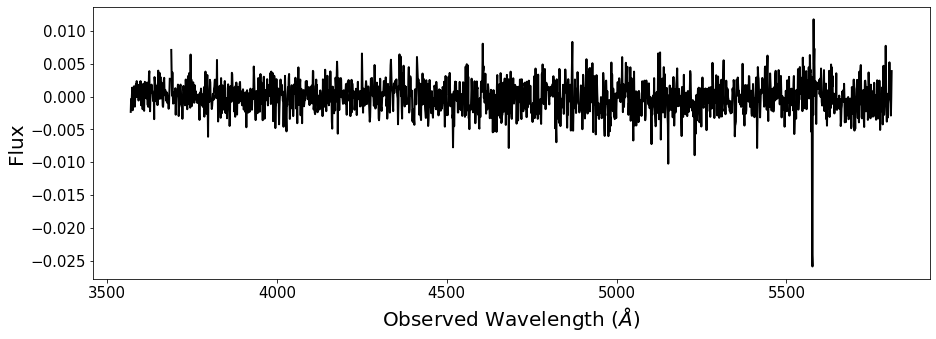

In [34]:
ex_spec = ifu_spec.IFU_spectrum(fits_1.dat[20], fits_1.wave, z=np.NaN, obj_name=None)
ex_spec.plot_spec()

##   auto_VP_run( ) 
- object describing a set of science frame observations for one grating setting

In [15]:
vp = auto_vp.auto_VP_run(data_path, fits_ext=0, guider_path=guider_path, dith_file=dith_file)
vp.auto_build_dither_groups()

Grouping Dithers in Observations
   Found 10 dither groups


In [16]:
vp.data_df

,filename,object,dith_num,obs_datetime,orig_fits_ext,is_dither,num_obj_obs
0,../20210411/redux/dark_20210410T203310_multi.fits,dark,1,2021-04-10 20:33:10,0,False,1.0
1,../20210411/redux/dark_20210410T204939_multi.fits,dark,1,2021-04-10 20:49:39,0,False,2.0
2,../20210411/redux/Feige66_dither_1_20210411T02...,Feige66,1,2021-04-11 02:35:19,0,True,3.0
3,../20210411/redux/Feige66_dither_2_20210411T02...,Feige66,2,2021-04-11 02:39:42,0,True,3.0
4,../20210411/redux/Feige66_dither_3_20210411T02...,Feige66,3,2021-04-11 02:44:04,0,True,3.0
5,../20210411/redux/Feige66_dither_4_20210411T02...,Feige66,4,2021-04-11 02:48:27,0,True,3.0
6,../20210411/redux/Feige66_dither_5_20210411T02...,Feige66,5,2021-04-11 02:52:46,0,True,3.0
7,../20210411/redux/Feige66_dither_6_20210411T02...,Feige66,6,2021-04-11 02:57:05,0,True,3.0
8,../20210411/redux/COOLJ0931_dither_1_20210411T...,COOLJ0931,1,2021-04-11 03:08:46,0,True,4.0
9,../20210411/redux/COOLJ0931_dither_2_20210411T...,COOLJ0931,2,2021-04-11 03:25:22,0,True,4.0


##  IFU_cube class( )
- object describing a data cube

##  multi_field_obs()
- object describing a observations of overlapping fields